In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import time

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist, mnist, cifar10
from tensorflow.keras.models import Model

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
import time

from IPython import display

In [4]:
(fmnist_train, fmnist_train_labels), (fmnist_test, fmnist_test_labels) = fashion_mnist.load_data()

fmnist_train = fmnist_train.reshape(fmnist_train.shape[0], 28, 28, 1).astype('float32') 
fmnist_test = fmnist_test.reshape(fmnist_test.shape[0], 28, 28, 1).astype('float32')

fmnist_train = (fmnist_train - 127.5) / 127.5 # Normalize the images to [-1, 1]
fmnist_test = (fmnist_test - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [5]:
(mnist_train, mnist_train_labels), (mnist_test, mnist_test_labels) = mnist.load_data()

mnist_train = mnist_train.reshape(mnist_train.shape[0], 28, 28, 1).astype('float32') 
mnist_test = mnist_test.reshape(mnist_test.shape[0], 28, 28, 1).astype('float32')

mnist_train = (mnist_train - 127.5) / 127.5 # Normalize the images to [-1, 1]
mnist_test = (mnist_test - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [6]:
# Load the CIFAR-10 dataset
(cifar_train, cifar_train_labels), (cifar_test, cifar_test_labels) = cifar10.load_data()

# Resize and convert to grayscale
new_size = (28, 28)
cifar_train_resized = np.zeros((cifar_train.shape[0], new_size[0], new_size[1], 1), dtype=np.uint8)
cifar_test_resized = np.zeros((cifar_test.shape[0], new_size[0], new_size[1], 1), dtype=np.uint8)

for i in range(cifar_train.shape[0]):
    resized_image = cv2.resize(cifar_train[i], new_size, interpolation=cv2.INTER_LINEAR)
    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_RGB2GRAY)
    cifar_train_resized[i, :, :, 0] = grayscale_image

for i in range(cifar_test.shape[0]):
    resized_image = cv2.resize(cifar_test[i], new_size, interpolation=cv2.INTER_LINEAR)
    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_RGB2GRAY)
    cifar_test_resized[i, :, :, 0] = grayscale_image

cifar_train = cifar_train_resized
cifar_test = cifar_test_resized

cifar_train = cifar_train.reshape(cifar_train.shape[0], 28, 28, 1).astype('float32') 
cifar_test = cifar_test.reshape(cifar_test.shape[0], 28, 28, 1).astype('float32')

cifar_train = (cifar_train - 127.5) / 127.5 # Normalize the images to [-1, 1]
cifar_test = (cifar_test - 127.5) / 127.5 # Normalize the images to [-1, 1]

# x_train_resized now contains CIFAR-10 images in 28x28x1 format
# You can use x_test_resized similarly for the test set


In [7]:
print(fmnist_train.shape, fmnist_test.shape)
print(mnist_train.shape, mnist_test.shape)
print(cifar_train.shape, cifar_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)
(60000, 28, 28, 1) (10000, 28, 28, 1)
(50000, 28, 28, 1) (10000, 28, 28, 1)


In [29]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(mnist_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

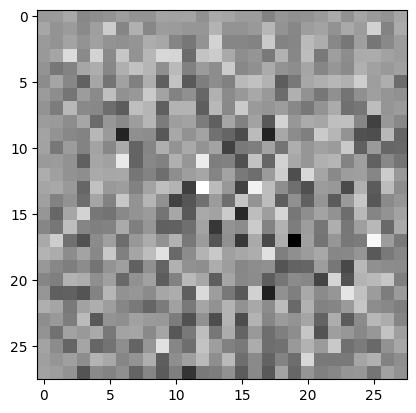

In [22]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [23]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00019504]], shape=(1, 1), dtype=float32)


In [24]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [25]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [26]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [27]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [28]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

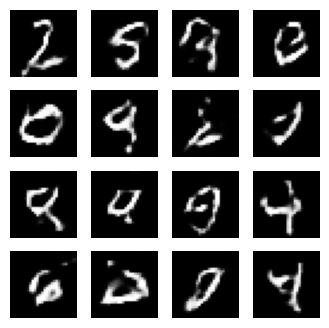

In [30]:
train(train_dataset, EPOCHS)

In [18]:
def predict(model, data, threshold=0.5):
  predictions = tf.keras.activations.sigmoid(model(data))
  return tf.math.greater(predictions, threshold)

def compute_accuracy(predictions):
     
    total_predictions = len(predictions)
    correct_predictions = np.sum(predictions)
    
    accuracy = correct_predictions / total_predictions
    return accuracy

In [ ]:
noise = tf.random.normal([1, 100])

In [31]:
threshold = 0.5

mnist_preds = predict(discriminator, mnist_test, threshold)
fmnist_preds = predict(discriminator, fmnist_test, threshold)
cifar_preds = predict(discriminator, cifar_test, threshold)

In [32]:
print(f'Accuracy on Mnist: {compute_accuracy(mnist_preds)}')
print(f'Detection accuracy on Fashion Mnist: {1- compute_accuracy(fmnist_preds)}')
print(f'Detection Accuracy on Cifar10: {1- compute_accuracy(cifar_preds)}')

Accuracy on Mnist: 0.6894
Detection accuracy on Fashion Mnist: 0.9973
Detection Accuracy on Cifar10: 1.0


In [39]:
predictions = tf.keras.activations.sigmoid(discriminator(mnist_test))
len(predictions)
x = tf.math.greater(predictions, 0.5)
len(x)
# print(predictions[:10], x[:10])

10000